<a href="https://colab.research.google.com/github/dmswneunju/DeepLearning_signiture/blob/master/ch09_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder
* 새로운 데이터를 생성하는 모델
* 데이터 셋 : MNIST  

encoder와 decoder 구조  
x data에 대한 확률분포를 나타낼 수 있는 잠재벡터를 구하고, 잠재벡터를 바탕으로 decoder를 사용해서 원본데이터와 유사한 형태의 데이터를 만들어낸다.  
decoder부분이 우리가 궁극적으로 만들고 싶은 generator부분

### [Step1] Load libraries & Datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
train_images = datasets.MNIST(
     root = 'data',
     train = True,
     download = True,
     transform = ToTensor()
 )
test_images = datasets.MNIST(
     root = 'data',
     train = 'False',
     download = True,
     transform = ToTensor()
 )

100%|██████████| 9912422/9912422 [00:00<00:00, 339751340.14it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25464724.37it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 159271599.57it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 18750520.44it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### [Step3] Set hyperparameters

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', DEVICE)

Using Device: cuda


### [Step4] Create DataLoader

In [ ]:
train_loader = DataLoader(train_images, batch_size = BATCH_SIZE, shuffle = True) 
test_loader = DataLoader(test_images, batch_size = BATCH_SIZE, shuffle = False)

### [Step5] Set Network Structure

In [ ]:
# Model
class VAE(nn.Module):
    def __init__(self, latent_dim):#latent_dim : encoder, decoder 사이에서 만들어지는 잠재벡터의 차원(z)
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),#default : inplace = false
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):            
        result = self.encoder(x)
        mu = self.fc_mu(result)
        var = self.fc_var(result)
        return mu, var

    def decode(self, z):
        result = self.decoder(z) #flatten시킨것을 encoder에 통과시킴
        return result   

    def reparameterize(self, mu, var):
        std = torch.exp(var / 2) #standard deviation : 표준편차
        eps = torch.randn_like(std) #입실론. std와 동일한 형태의 차원을 가진 random data set 생성
        return mu + (eps * std) 

    def forward(self, x):
        x = self.flatten(x)
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        out = self.decode(z)
        return  out, mu, var


### [Step6] Create Model instance

In [ ]:
model = VAE(10).to(DEVICE)
print(model)

VAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=10, bias=True)
  (fc_var): Linear(in_features=256, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### [Step7] Model compile

In [ ]:
def loss_function(recon_x, x, mu, var):
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum') #x와 모델을 통과한 후 복원된 x'과의 차이를 최소화 시키기 위한 loss값
    kl_loss = -0.5 * torch.sum(1 + var - mu.pow(2) - var.exp()) #원본데이터에 대한 확률밀도함수와 추정한 확률밀도함수간의 차이
    return recon_loss + kl_loss

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
for batch in train_loader:
    print(batch)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

### [Step8] Set train loop

In [ ]:
def train(train_loader, model, loss_fn, optimizer):
    model.train()
    
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        decoded, mu, var = model(X)

        # 손실 계산
        loss = loss_fn(decoded, X, mu, var) #(복원된 값, 원본데이터, , )

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #최적화

    #마지막에 위치한 배치의 5번째까지의 data
    origin_data = X[:5].view(-1, 28*28).type(torch.FloatTensor)/255. 
    #decoding된 결과값
    decoded_data = decoded[:5].view(-1, 28*28).type(torch.FloatTensor)/255.


    #각각의 데이터 show
    f, axs = plt.subplots(2, 5, figsize=(5,2))
    for i in range(5):
        img = np.reshape(origin_data.data.numpy()[i],(28,28))
        axs[0][i].imshow(img, cmap='gray')
        axs[0][i].set_xticks(())
        axs[0][i].set_yticks(())
    
    for i in range(5):
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i],(28,28))
        axs[1][i].imshow(img, cmap='gray')
        axs[1][i].set_xticks(())
        axs[1][i].set_yticks(())
    plt.show()

Epoch 1 
------------------


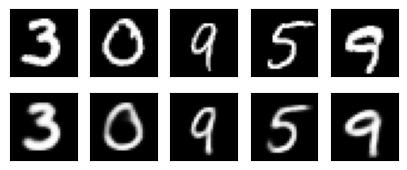

Epoch 2 
------------------


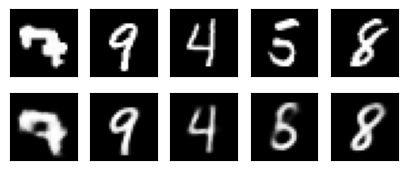

Epoch 3 
------------------


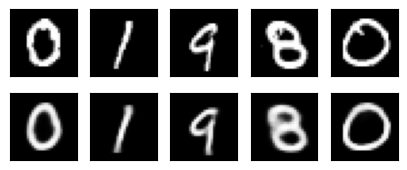

Epoch 4 
------------------


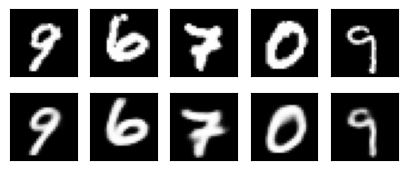

Epoch 5 
------------------


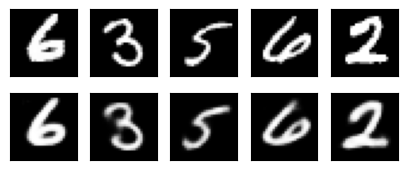

Epoch 6 
------------------


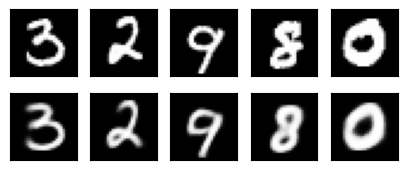

Epoch 7 
------------------


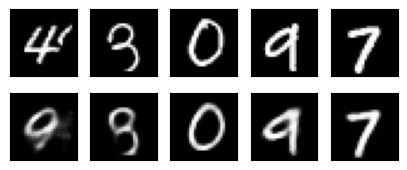

Epoch 8 
------------------


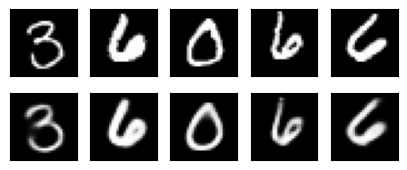

Epoch 9 
------------------


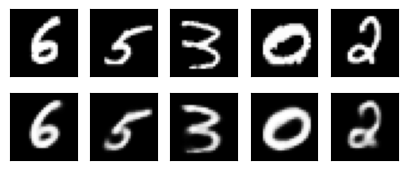

Epoch 10 
------------------


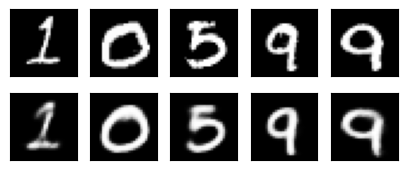

In [ ]:
for i in range(EPOCHS):
    print(f"Epoch {i+1} \n------------------")
    train(train_loader, model, loss_function, optimizer)